在介绍softmax回归的实现前我们先引入一个多类图像分类数据集。它将在后面的章节中被多次使用，以方便我们观察比较算法之间在**模型精度**和**计算效率上的区别**。图像分类数据集中最常用的是手写数字识别数据集MNIST [1]。但大部分模型在MNIST上的分类精度都超过了95%。为了更直观地观察算法之间的差异，我们将使用一个图像内容更加复杂的数据集Fashion-MNIST [2]。

## 3.5.1. 获取数据集

首先导入本节需要的包或模块。

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import time
import sys
import matplotlib.pyplot as plt

下面，我们通过keras的dataset包来下载这个数据集。第一次调用时会自动从网上获取数据。我们通过参数train来指定获取训练数据集或测试数据集（testing data set）。测试数据集也叫测试集（testing set），只用来评价模型的表现，并不用来训练模型。

In [2]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


训练集中和测试集中的每个类别的图像数分别为6,000和1,000。因为有10个类别，所以训练集和测试集的样本数分别为60,000和10,000。

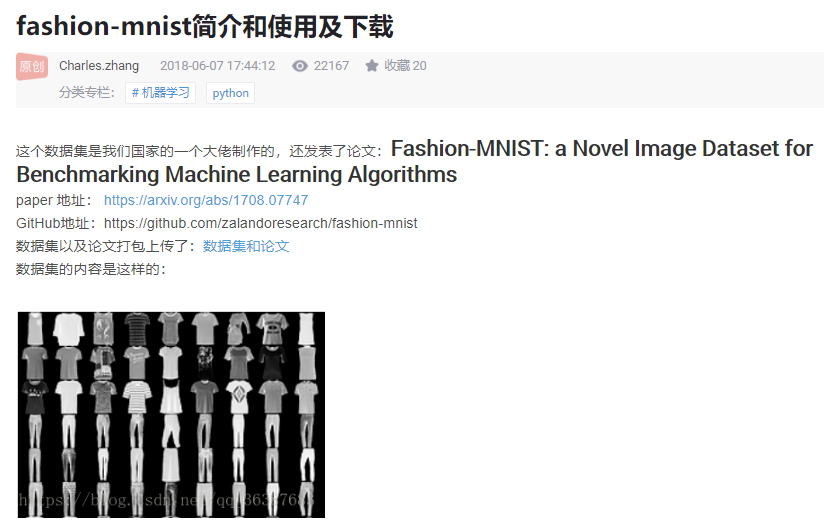

In [4]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

我们可以通过方括号[]来访问任意一个样本，下面获取第一个样本的图像和标签。

In [5]:
feature,label=x_train[0],y_train[0]

变量feature对应高和宽均为28像素的图像。每个像素的数值为0到255之间8位无符号整数（uint8）。它使用二维的`numpy.ndarray`存储。因为数据集中是灰度图像，所以只有两个维度，不需要第三个维度来区分通道。为了表述简洁，我们将高和宽分别为 h 和 w 像素的图像的形状记为 h×w 或（h，w）。

In [8]:
feature.shape, feature.dtype

((28, 28), dtype('uint8'))

图像的标签使用NumPy的标量表示。注意，在keras的fashion_mnist数据和原书mxnet提供的数据集有差别

In [9]:
label, type(label), label.dtype

(9, numpy.uint8, dtype('uint8'))

Fashion-MNIST中一共包括了10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。以下函数可以将数值标签转成相应的文本标签。

In [12]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

下面定义一个可以在一行里画出多张图像和对应标签的函数。

In [13]:
def show_fashion_mnist(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.reshape((28, 28)))   # 这里也不熟。。
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)   # 这里的用法要好好学习下~
        f.axes.get_yaxis().set_visible(False)
    plt.show()

现在，我们看一下训练数据集中前9个样本的图像内容和文本标签

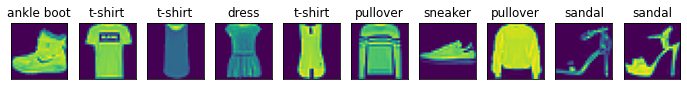

In [14]:
X, y = [], []
for i in range(10):
    X.append(x_train[i])
    y.append(y_train[i])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## 3.5.2. 读取小批量

我们将在训练数据集上训练模型，并将训练好的模型在测试数据集上评价模型的表现。虽然我们可以像“线性回归的从零开始实现”一节中那样通过 `yield` 来定义读取小批量数据样本的函数，但为了代码简洁，这里我们直接创建 `tf.data.Dataset.from_tensor_slices` 实例。该实例每次读取一个样本数为`batch_size`的小批量数据。这里的批量大小`batch_size`是一个超参数。

In [19]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

最后我们查看读取一遍训练数据需要的时间。

In [20]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

0.19 sec


## 3.5.3. 小结

* Fashion-MNIST是一个10类服饰分类数据集，之后章节里将使用它来检验不同算法的表现。
* 我们将高和宽分别为 h 和 w 像素的图像的形状记为 h×w 或（h，w）。